In [12]:
TASK = [
    "RETRIEVAL_DOCUMENT",
    "QUESTION_ANSWERING",
    "FACT_VERIFICATION",
    "CODE_RETRIEVAL_QUERY",
    "RETRIEVAL_QUERY",
    "CLASSIFICATION",
    "CLUSTERING",
    "SEMANTIC_SIMILARITY",
]

### 각 task_type 별 Performance.csv 파일 불러오기

In [13]:
# 1) 경로 설정 + 데이터 로드
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

cwd = Path.cwd()
if cwd.name == "performance":
    target_dir = Path(".")
else:
    target_dir = Path("performance")

csv_files = [
    target_dir / f"model_performance_{t}.csv"
    for t in TASK
    if (target_dir / f"model_performance_{t}.csv").exists()
]
dfs = []
for p in csv_files:
    df = pd.read_csv(p, encoding="utf-8-sig")
    df.columns = [c.strip() for c in df.columns]
    # 필요한 컬럼만 유지 (표준편차가 있으면 함께 보존)
    cols = ["Metric", "Average"]
    if "Std. Deviation" in df.columns:
        cols.append("Std. Deviation")
    elif "Std Deviation" in df.columns:
        df = df.rename(columns={"Std Deviation": "Std. Deviation"})
        cols.append("Std. Deviation")
    elif "Std" in df.columns:
        df = df.rename(columns={"Std": "Std. Deviation"})
        cols.append("Std. Deviation")
    df = df[cols].copy()
    df["task_type"] = p.stem.replace("model_performance_", "")
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
metric_order = ["MSE", "RMSE", "MAE", "MAPE (%)"]

### 4개 지표 막대그래프

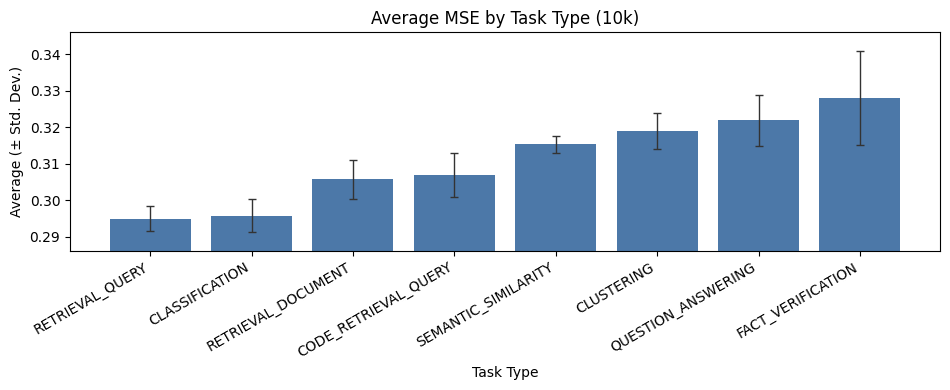

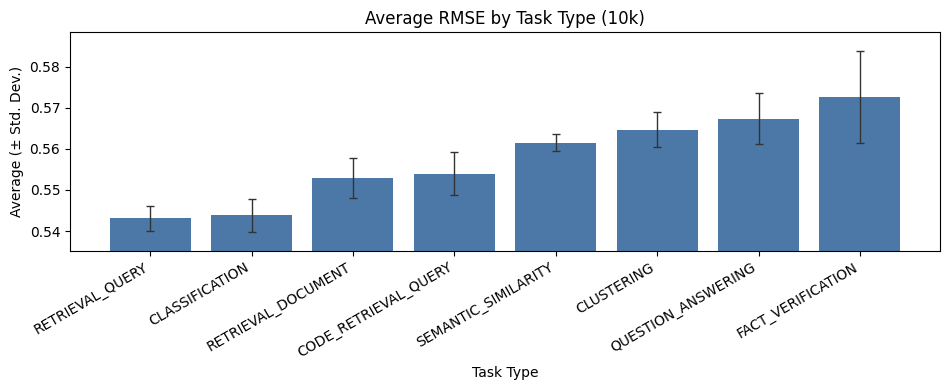

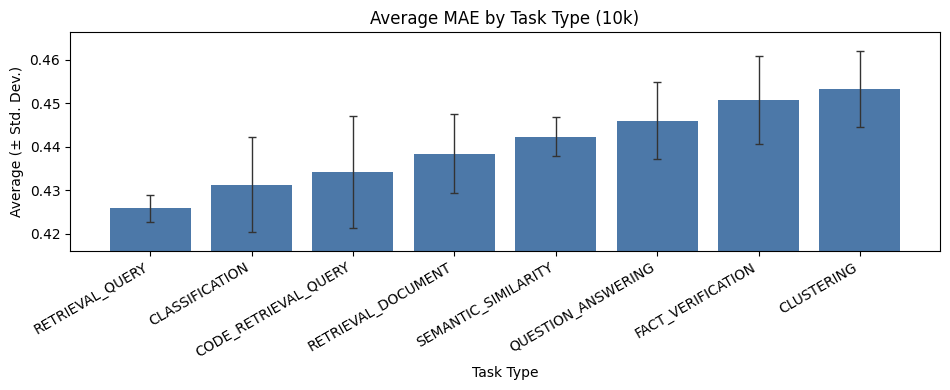

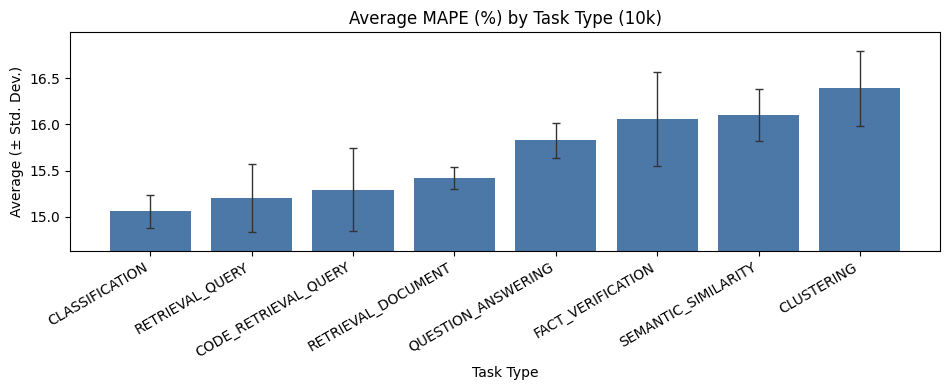

In [14]:
for metric in [m for m in metric_order if m in all_df["Metric"].unique()]:
    # 값이 낮은 순서(오름차순)로 정렬
    sub = all_df[all_df["Metric"] == metric].sort_values(["Average", "task_type"])
    fig = plt.figure(figsize=(max(6, 1.2 * sub["task_type"].nunique()), 4))
    err = sub["Std. Deviation"] if "Std. Deviation" in sub.columns else None
    err_kw = dict(elinewidth=1, ecolor="#333333", capsize=3)
    plt.bar(
        sub["task_type"], sub["Average"], color="#4C78A8", yerr=err, error_kw=err_kw
    )
    plt.title(f"Average {metric} by Task Type (10k)")
    plt.xlabel("Task Type")
    plt.ylabel("Average (± Std. Dev.)")
    plt.xticks(rotation=30, ha="right")
    if err is not None:
        y_min = float((sub["Average"] - err).min())
        y_max = float((sub["Average"] + err).max())
    else:
        y_min = float(sub["Average"].min())
        y_max = float(sub["Average"].max())
    y_range = max(1e-6, y_max - y_min)
    margin = y_range * 0.1
    plt.ylim(y_min - margin, y_max + margin)
    fname = (
        target_dir
        / f"bar_{metric.replace('%','pct').replace(' ','_').replace('(','').replace(')','')}_10k.png"
    )
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.show()
    plt.close(fig)

### 각 task_type 별 rmse/mae 산점도

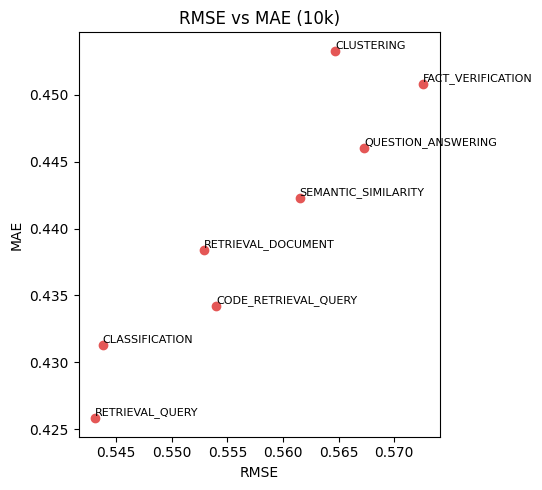

In [15]:
sub = all_df[all_df["Metric"].isin(["RMSE", "MAE"])]
pivot = sub.pivot(index="task_type", columns="Metric", values="Average").reindex(
    sorted(sub["task_type"].unique())
)
fig = plt.figure(figsize=(5.5, 5))
plt.scatter(pivot["RMSE"], pivot["MAE"], color="#E45756")
for t, x, y in zip(pivot.index, pivot["RMSE"], pivot["MAE"]):
    plt.text(x, y, t, fontsize=8, ha="left", va="bottom")
plt.title("RMSE vs MAE (10k)")
plt.xlabel("RMSE")
plt.ylabel("MAE")
plt.tight_layout()
fname = target_dir / "scatter_RMSE_vs_MAE_10k.png"
plt.savefig(fname, dpi=150)
plt.show()
plt.close(fig)